In [1]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials import mnist

In [2]:
data=mnist.input_data.read_data_sets("../../Neural networks/MNIST_data")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../Neural networks/MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../Neural networks/MNIST_data\train-labels-idx1-ubyte.gz
Extracting ../../Neural networks/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ../../Neural networks/MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
images=data.train.images/255.
images.shape

(55000, 784)

In [4]:
tf.reset_default_graph()
X=tf.placeholder("float32",shape=(None,784),name="input")
Y=tf.placeholder("float32",shape=(None,64),name="gen_input")

In [5]:
#Model

#encoder
with tf.variable_scope("encoder",reuse=tf.AUTO_REUSE):
    L1=tf.keras.layers.Dense(units=784,activation="relu",name="enc_input")(X)
    L2=tf.keras.layers.Dense(units=256,activation="relu")(L1)
            
#encodings
with tf.variable_scope("encoding",reuse=tf.AUTO_REUSE):
    encoding_mean=tf.keras.layers.Dense(64)(L2)
    encoding_stddev=tf.keras.layers.Dense(64)(L2)
    #sampling
    std_norm=tf.random_normal(shape=(tf.shape(encoding_mean)[0], 64), mean=0, stddev=1)
    Sample=encoding_mean + tf.exp(encoding_stddev) * std_norm
     
#Latent Vector
with tf.variable_scope("Latent_vector",reuse=tf.AUTO_REUSE):
    Lt_vec=tf.keras.layers.Dense(64,name="Latent_vector")(Sample)

#decoding
with tf.variable_scope("decoder",reuse=tf.AUTO_REUSE):
    dec_in=tf.keras.layers.Dense(256,activation="relu",name="dec_input")
    dec_out=tf.keras.layers.Dense(784,activation="relu",name="output")
    L3=dec_in(Lt_vec)
    L4=dec_out(L3)

#gen_output
gen_dec=dec_in(Y)
output=dec_out(gen_dec)

In [8]:
#Loss
out=L4

rec_loss=tf.reduce_sum(tf.square(X-out))

Kl_loss= 0.5 * tf.reduce_sum(tf.square(encoding_mean)+tf.square(tf.exp(encoding_stddev)) -1 -encoding_stddev)

Loss= tf.reduce_mean(rec_loss + Kl_loss,name="net_loss") 


In [9]:
#optimizing

opti=tf.train.AdamOptimizer(name="opti")
step=opti.minimize(Loss,name="step")


In [10]:
#Session
Sess=tf.Session()
Sess.run(tf.global_variables_initializer())

In [11]:
# Train
batch_size = 100
for i in range(5):
    num_batches = int(data.train.num_examples/batch_size)
    total_cost = 0
    for j in range(num_batches):
        batch_x, batch_y = data.train.next_batch(batch_size)
        c, _ = Sess.run([Loss, step], feed_dict={X:batch_x})
        total_cost += c
    print(total_cost)

1868894.1018066406
1331646.4157714844
1229359.8580322266
1184940.6867675781
1155878.3272705078


Text(0.5,1,'Generated_image')

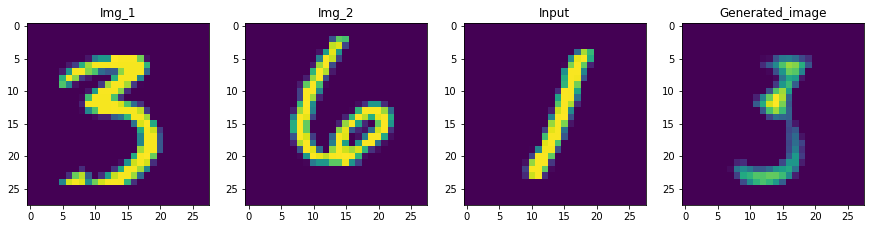

In [23]:
k=np.random.randint(size=(1,),low=0,high=7900)[0]
out0=Sess.run(Lt_vec,feed_dict={X:data.train.images[k:k+1]})
out1=Sess.run(Lt_vec,feed_dict={X:data.train.images[99+k:k+100]})
out2=Sess.run(Lt_vec,feed_dict={X:data.train.images[k+14:k+15]})
diff=out0-out1
new_vec=(out2+diff)


ans=Sess.run(output,feed_dict={Y:new_vec})

fig=plt.figure(figsize=(15,15))
ax1=fig.add_subplot(1,4,1)
ax2=fig.add_subplot(1,4,2)
ax3=fig.add_subplot(1,4,3)
ax4=fig.add_subplot(1,4,4)

ax1.imshow(data.train.images[k:k+1].reshape(28,28))
ax2.imshow(data.train.images[k+99:k+100].reshape(28,28))
ax3.imshow(data.train.images[k+14:k+15].reshape(28,28))
ax4.imshow(ans.reshape(28,28))

ax1.set_title("Img_1")
ax2.set_title("Img_2")
ax3.set_title("Input")
ax4.set_title("Generated_image")

In [13]:
#Saving
saver=tf.train.Saver()

In [14]:
saver.save(Sess,"mymodel/vae")

'mymodel/vae'